# Machine Learning vs. March Madness

Authors: [Matthew Reinhart](https://www.linkedin.com/in/matthew-reinhart-1bb372173/), [Mendy Nemanow](https://www.linkedin.com/in/mendy-nemanow-2594ab225/), [Paul Lindquist](https://www.linkedin.com/in/paul-lindquist/), [TJ Bray](https://www.linkedin.com/in/thomas-tj-bray-24499354/)

## Overview
***

Sports gambling is one of the fastest growing industries in the country, with states continuing to pass betting-friendly legislation and companies like DraftKings, FanDuel and BetMGM experiencing increased, year-over-year revenue. One of the premier sports betting events of the year is the NCAA college basketball postseason tournament, commonly known as March Madness.

We target college basketball because of our domain knowledge and the talent disparity within the sport. In professional sports, the talent gap between the best and worst teams is very small. It's unusual to see NBA spreads greater than 10 points. In college basketball, this happens regularly. Teams are 25-point underdogs on a given night and that creates betting opportunity. There also tends to be more regular competition in college basketball. With only around 30 games in a season, teams don't have the luxury to take nights off like we see in an 82-game NBA season. And with constant effort comes more predictable outcomes.

## Business Objective
***

This project posits that we run a sports gambling company. We offer our customers advisory services during the busiest time of the sports year on events with the greatest amount of betting action.

To maximize returns, we run a series of machine learning algorithms to model predictions for single games in the NCAA tournament. We pay particular focus to accurately predicting underdog team wins, as doing so yields higher payouts. Accuracy, and more specifically predictive accuracy, is paramount in selecting our models, as we strive to minimize risk for our customers.

## Data
***

This project uses datasets from Kaggle's *[March Machine Learning Mania 2021](https://www.kaggle.com/c/ncaam-march-mania-2021/data)* competition.

## Methodology
***

We set the win/loss outcome for the favored team as the binary target variable, with 1 equaling a win for the favored team and 0 equaling a win for the underdog. Rankings are assigned using the reputable KenPom ratings.

We then use an iterative approach to build 6 predictive, classification models: Logistic Regression, K-Nearest Neighbors, Decision Tree, Random Forest, Bagging classifier and XGBoost. We utilize hyperparameter tuning, cross-validation and scoring to select the highest performing, predictive models. This approach is applied to regular season, postseason and cumulative postseason data.

# Data Cleaning
***

The files we downloaded from kaggle include in game stats for all seasons from 2003 up to 2020. Our predcitions are going to be based off the season average stats of the two relevant teams in each game. In order to get this we have to calculate the averages from all the games they played up to that point in the season, and make a new dataframe for the specific game with averages as input.

We then need to make a target variable. The difficulty with this dataset is, we would like to predict whether the favorite team (based on Ken Pom rankings) won the game for betting purposes, and this dataset does not include a team raking. We had to use another dataset from kaggle which includes the team rankings, check if the winning team in the game was the favorite, and then make a binary column of Favorite Win. 

Ken Pomeroy, the creator of KenPom, uses analytical measures to rank each team in college basketball. He is one of the most popular and well-known names in basketball analytics and has been at the forefront of the progression mainstream acceptance of advanced stats.

Once we have a target column, we can create a dataframe with full seasons worth of games with a target column, and train our model on it.

In [1]:
# Import the relevant packages
import time 
start_time = time.time()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, \
recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Notebook in repo
from function_notebook_1 import *

In [3]:
# Importing a regular season dataframe, a postseason dataframe, a rankings dataframe, 
# and a dataframe with Ken Pom ranking from the rankings dataframe. 

regularseason = pd.read_csv('Kaggle_Datasets/MRegularSeasonDetailedResults.csv')
postseason = pd.read_csv('Kaggle_Datasets/MNCAATourneyDetailedResults.csv')
rankings = pd.read_csv('Kaggle_Datasets/MMasseyOrdinals.csv')
kenpom = rankings[(rankings['SystemName'] == 'POM') & (rankings['RankingDayNum'] >= 128)]

We want to have some more advanced stats to use for prediction. We create them here with a few calculations from the regular stats.

In [4]:
def add_rate_cols(df):
    # Calculates the number of possesions for each team in each game. The number of possessions
    # has a large effect on teams averages and counting stats. Knowing this tells us how
    # efficient a team is different factors of a game.
    df['possessions'] = .5 * (df['FGA'] + (.475 * df['FTA']) - df['OR'] + df['TO'])
    
    # Effective Field Goal Percentage (eFG) gives extra value to 3-point shots. Each 3-pointer made
    # is given the weight of 1.5 2-pointers made.
    df['eFG'] = (df['FGM'] + (.5 * df['FGM3'])) / df['FGA']
    
    # True Shooting Percentage (TS%) gives weight to the 3-point shot as well as free throws made.
    # This stat takes in account all types of scoring to determine a players shooting percentage.
    df['TS%'] = df['Score'] / (2 * (df['FGA'] + .475 * df['FTA']))
    
    # Free Throw Rate (FTr) is a simple ratio of Free Throws to Field Goals Attempted. It identifies
    # a team's abiilty to draw fouls and get to the free throw line where expected value is high.
    df['FTr'] = df['FTA'] / df['FGA']
    
    # Three Point Attempt Rate (3PAr) shows how often a player shoots 3-pointers compared to other
    # types of shots. It identifies players who attack the basket and draw fouls and players who are
    # likely to stand outside and shoot.
    df['3PAr'] = df['FGA3'] / (df['FGA'] + (.475*df['FTA']))
    
    # Offensive Rebound Percentage (OR%) is the number of offensive rebounds a team gets compared
    # to the total number of rebounds available while they were on offense.
    df['OR%'] = df['OR'] / (df['OR'] + df['Opp_DR'])
    
    # Defensive Rebound Percentage (DR%) is the number of defensive rebounds a team gets compared
    # to the total number of rebounds available while they were on defense.
    df['DR%'] = df['DR'] / (df['DR'] + df['Opp_OR'])
    
    # Rebound Percentage (REB%) is the percentage of rebounds from all available rebounds a team
    # gets in a game.
    df['REB%'] = (df['OR'] + df['DR']) / (df['OR'] + df['Opp_DR'] + df['Opp_OR'] + df['DR'])
    
    # Total Rebounds (TR) the number of rebounds a team gets in a game.
    df['TR'] = (df['OR'] + df['DR'])
    
    # Assist to Turnover Ratio (ATOr) shows how well a team takes care of the ball. The higher the
    # the number the better a team is at passing the ball and playing together.
    df['ATOr'] = df['Ast'] / df['TO']
    
    # Assist Percentage (Ast%) is the number of assists a team has compared to baskets scored. The
    # higher this percentage the better the team is at playing together and creating baskets for
    # one another.
    df['Ast%'] = df['Ast'] / df['FGM']
    
    # Steal Percentage (Stl%) is the rate at which a team gets steals during other teams possessions.
    df['Stl%'] = df['Stl'] / (df['Opp_FGA'] + .475*df['Opp_FTA'] + df['Opp_TO'])
    
    # Block Percentage (Blk%) is the rate at which a team blocks shots during other teams possessions.
    df['Blk%'] = df['Blk'] / (df['Opp_FGA'])
    
    # Turnover Percentage (TO_r) is the rate at which a team turnovers the ball over during their own
    # possessions.
    df['TO_r'] = df['TO'] / (df['FGA'] + .475*df['FTA'] + df['TO'])
    
    # Opponent Effective Field Goal Percentage (Opp_eFG) is a defensive measure that shows the Effective
    # Field Goal Percentage of a team's opponents.
    df['Opp_eFG'] = (df['Opp_FGM'] + (.5 * df['Opp_FGM3'])) / df['Opp_FGA']
    
    # Opponent True Shooting Percentage (Opp_TSpct) is a defensive measure that shows the True Shooting
    # Percentage of a team's opponents.
    df['Opp_TSpct'] = df['Opp_Score'] / (2 * (df['Opp_FGA'] + .475 * df['Opp_FTA']))
    
    # Opponent Free Throw Rate (Opp_FTr) is a defensive measure that shows how often a team fouls their
    # opponents and allows them to shoot free throws.
    df['Opp_FTr'] = df['Opp_FTA'] / df['Opp_FGA']
    
    # Opponent Three Point Rate (Opp_3Pr) is a defensive rate measure of how many 3-pointers an
    # opponent makes per basket scored.
    df['Opp_3Pr'] = df['Opp_FGA3'] / (df['Opp_FGA'] + (.475*df['Opp_FTA']))
    
    # Opponent Total Rebounds (Opp_TR) is the number of rebounds a team's opponent gets in a game.
    df['Opp_TR'] = (df['Opp_OR'] + df['Opp_DR'])
    
    # Opponent Assist to Turnover Ratio (Opp_ATOr) is a defensive rate measure of an opponents
    # assists per turnover. This is a good measure of defensive aggressiveness and the ability to make
    # opponents work hard for their shots.
    df['Opp_ATOr'] = df['Opp_Ast'] / df['Opp_TO']
    
    # Opponent Assist Percentage (Opp_Ast_%) is the percentage of opponent's baskets that are assisted.
    df['Opp_Ast_%'] = df['Opp_Ast'] / df['Opp_FGM']
    
    # Opponent Steal Percentage (Opp_Stl_%) is the percentage possesions that end with the opponent getting
    # a steal.
    df['Opp_Stl_%'] = df['Opp_Stl'] / (df['FGA'] + .475*df['FTA'] + df['TO'])
    
    # Opponent Block Percentage (Opp_Blk_%) is the percentage of opponent's possessions that end in a
    # block.
    df['Opp_Blk_%'] = df['Opp_Blk'] / (df['FGA'])
    
    # Opponent Turnover Rate (Opp_TO_r) is the percentage of opponent's possesions that end in a 
    # turnover.
    df['Opp_TO_r'] = df['Opp_TO'] / (df['Opp_FGA'] + .475*df['Opp_FTA'] + df['Opp_TO'])

    return df

This function will take all the in-game stats of a teams season, and put it into one dataframe. Then (if the paramter average is set to True), put that into a single row with the teams averages.

In [5]:
# This function is used to get the stats for a team in the regular season. The parameters are:
# the team id number, the season, the day number of the season, and whether you want to see
# each individual game or the season averages.

def team_regular_season(team_id,Season = all, DayNum = all, average = True):
    
    # create a dataframe that has all the wins/losses of a team during the season up to the given day number.
    teamwins = regularseason[(regularseason['WTeamID'] == team_id) & (regularseason['Season'] == Season) & (regularseason['DayNum'] < DayNum)] 
    teamlosses = regularseason[(regularseason['LTeamID'] == team_id) & (regularseason['Season'] == Season) & (regularseason['DayNum'] < DayNum)]
    
    # split the dataframes to only have the offensive statistics of the given team
    teamwinsoffense = teamwins.filter(like = 'W')    
    teamlossesoffense = teamlosses.filter(like = 'L')

    # split the dataframes to only have the defensive statistics of the given team
    teamwinsoffense.columns = teamwinsoffense.columns.str.lstrip('W')
    teamlossesoffense.columns = teamlossesoffense.columns.str.lstrip('L')

    # concat the two offensive dataframes
    teamoffense = pd.concat([teamwinsoffense, teamlossesoffense])

    # create oppposing team statistics from the given games
    teamwinsopponents = teamwins.filter(like = 'L')
    teamlossesopponents = teamlosses.filter(like = 'W')

    # rename the columns from the opponent statistics dataframes
    teamwinsopponents.columns = teamwinsopponents.columns.str.lstrip('L')
    teamlossesopponents.columns = teamlossesopponents.columns.str.lstrip('W')

    # concat the dataframes from opponent wins and losses
    teamopponents = pd.concat([teamwinsopponents, teamlossesopponents])
    
    # concat the team stats and the opponent stats to create a full picture of the team's season
    teamtotal = pd.concat([teamoffense, teamopponents.add_prefix('Opp_')], axis = 1)
    
    teamtotal.drop('Opp_TeamID', axis = 1, inplace = True)
    
    # return either the season averages or the game by game statistics
    if average == True:
        teamtotal = teamtotal.groupby('TeamID').mean().reset_index()
        add_rate_cols(teamtotal)
    
    if average == False:
        add_rate_cols(teamtotal)
        
    return teamtotal

In [6]:
# Here's an example of a team_regular_season output.
start = time.time()
marquette = team_regular_season(1266, 2020, 132, True)
end = time.time()
print('Execution time = %.6f seconds' % (end-start))
marquette

Execution time = 0.064217 seconds


,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,...,Opp_eFG,Opp_TSpct,Opp_FTr,Opp_3Pr,Opp_TR,Opp_ATOr,Opp_Ast_%,Opp_Stl_%,Opp_Blk_%,Opp_TO_r
0,1266,77.766667,25.3,58.866667,10.033333,26.233333,17.133333,23.066667,10.7,29.266667,...,0.467952,0.500821,0.34818,0.298768,35.033333,1.200608,0.521108,0.080951,0.052095,0.132957


Now we get the end of year rankings of a team for a specific year with this function.

In [7]:
def get_KenPom(team_id, Year):
    rank = kenpom[(kenpom['TeamID'] == team_id) & (kenpom['Season'] == Year)]
    rank.reset_index(inplace = True)
    return rank.OrdinalRank

get_KenPom(1181, 2020)

0    5
Name: OrdinalRank, dtype: int64

This function will take in a specified matchup and output a game with the two teams season stats and whether the favorite team one.

In [8]:
def single_game(team1_id, team2_id, Year = 2020, DayNum = 132):
    
    # from the Team IDs get a dataframe with the average seasonlong team statistics.
    team1 = team_regular_season(team1_id,Year,DayNum)
    team2 = team_regular_season(team2_id,Year,DayNum)
    
    # get the Ken Pom ranking for each team
    team1Pom = get_KenPom(team1_id, Year)
    team2Pom = get_KenPom(team2_id, Year)
    
    # due to the structure of the original dataframe, the first team listed is always the winner.
    # we check if the favorite won by comparing the rankings of the two teams.
    fav_win = pd.DataFrame(team1Pom.lt(team2Pom))
    
    # concatenate the dataframes and return the single game pre-game data.
    game = pd.concat([team1.add_prefix('W_'), team2.add_prefix('L_'), fav_win], axis = 1)
    game.rename(columns={game.columns[106]: 'fav_win'}, inplace = True)
    
    return game

This code shows how the stats from the function "single_game" update throughout the season. In this 
hypothetical example Duke plays North Carolina during the 2020 season on four separate occasions. On Day 0
there are no stats available so all the values are 'Nan'. On Day 2, only Duke has played a game, they have
stats available, however, North Carolina has not, so their values are all 'Nan'. On Day 50, both teams have
played and have available stats. On Day 100, both teams have continued deep into their seasons and have
updated statistics from the first 100 days of the year.

In [9]:
duke_unc = single_game(1181, 1314, 2020, 0)
duke_unc

,W_TeamID,W_Score,W_FGM,W_FGA,W_FGM3,W_FGA3,W_FTM,W_FTA,W_OR,W_DR,...,L_Opp_TSpct,L_Opp_FTr,L_Opp_3Pr,L_Opp_TR,L_Opp_ATOr,L_Opp_Ast_%,L_Opp_Stl_%,L_Opp_Blk_%,L_Opp_TO_r,fav_win
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [10]:
duke_unc = single_game(1181, 1314, 2020, 2)
duke_unc

,W_TeamID,W_Score,W_FGM,W_FGA,W_FGM3,W_FGA3,W_FTM,W_FTA,W_OR,W_DR,...,L_Opp_TSpct,L_Opp_FTr,L_Opp_3Pr,L_Opp_TR,L_Opp_ATOr,L_Opp_Ast_%,L_Opp_Stl_%,L_Opp_Blk_%,L_Opp_TO_r,fav_win
0,1181,68,23,64,8,24,14,23,11,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [11]:
duke_unc = single_game(1181, 1314, 2020, 25)
duke_unc

,W_TeamID,W_Score,W_FGM,W_FGA,W_FGM3,W_FGA3,W_FTM,W_FTA,W_OR,W_DR,...,L_Opp_TSpct,L_Opp_FTr,L_Opp_3Pr,L_Opp_TR,L_Opp_ATOr,L_Opp_Ast_%,L_Opp_Stl_%,L_Opp_Blk_%,L_Opp_TO_r,fav_win
0,1181,83.857143,29.714286,66.285714,7.0,21.0,17.428571,26.285714,16.428571,27.857143,...,0.465617,0.184896,0.40936,32.0,1.085714,0.527778,0.078417,0.03866,0.143524,True


In [12]:
duke_unc = single_game(1181, 1314, DayNum = 100)
duke_unc

,W_TeamID,W_Score,W_FGM,W_FGA,W_FGM3,W_FGA3,W_FTM,W_FTA,W_OR,W_DR,...,L_Opp_TSpct,L_Opp_FTr,L_Opp_3Pr,L_Opp_TR,L_Opp_ATOr,L_Opp_Ast_%,L_Opp_Stl_%,L_Opp_Blk_%,L_Opp_TO_r,fav_win
0,1181,82.583333,30.125,62.791667,6.958333,19.833333,15.375,21.958333,12.875,26.958333,...,0.517736,0.287568,0.358779,34.916667,1.122807,0.528053,0.082791,0.063984,0.146231,True




We can now write a function to create a full seasons worth of games using the single_game function to concatenate all of the single games of a season into one DataFrame. 

In [13]:
def create_season_df(df, season):
    
    # create a DataFrame for the season we are looking for
    season_df = df[(df['Season'] == season) & (df['DayNum'] >= 12)]
    season_df.reset_index(inplace = True)
    
    # create a list with the two teams, winning team always first, the season, and the day number of the game
    matchups = list(zip(season_df.WTeamID, season_df.LTeamID, season_df.Season, season_df.DayNum))
    
    season_games = []
    
    # iterate through the list we created and create each single game matchup throughout the season
    for i in range(len(matchups)):
        game = single_game(matchups[i][0], matchups[i][1], Year = matchups[i][2], DayNum = matchups[i][3])
        season_games.append(game)
    
    # from the season games list concatenate all the outputted DataFrames and insert the location
    # of the winner (home, away, neutral)
    df = pd.concat(season_games, axis = 0).dropna()
    df.reset_index(inplace = True, drop = True)
    df.insert(0,"w_loc", season_df.WLoc)
    
    return df

Now we can simply run this last function on each season and each postseason. With that, our data cleaning is complete.

In [14]:
# ###7.5 seconds to run
# start_time = time.time()

# postseason12 = create_season_df(postseason, 2012)

# end_time = time.time()
# print('Execution time = %.6f seconds' % (end_time-start_time))

The following is very computationally expensive. Because of that, we saved these data frames as csv files so we never need to create these dataframes again. We'll comment out those lines of code.

In [15]:
# postseason13 = create_season_df(postseason, 2013)
# postseason14 = create_season_df(postseason, 2014)
# postseason15 = create_season_df(postseason, 2015)
# postseason16 = create_season_df(postseason, 2016)
# postseason17 = create_season_df(postseason, 2017)
# postseason18 = create_season_df(postseason, 2018)
# postseason19 = create_season_df(postseason, 2019)

In [16]:
# start_time = time.time()

# regularseason12 = create_season_df(regularseason, 2012)

# end_time = time.time()
# print('Execution time = %.6f seconds' % (end_time-start_time))

In [17]:
# regularseason13 = create_season_df(regularseason, 2013)

In [18]:
# regularseason14 = create_season_df(regularseason, 2014)

In [19]:
# regularseason15 = create_season_df(regularseason, 2015)

In [20]:
# regularseason16 = create_season_df(regularseason, 2016)

In [21]:
# regularseason17 = create_season_df(regularseason, 2017)

In [22]:
# regularseason18 = create_season_df(regularseason, 2018)

In [23]:
# regularseason19 = create_season_df(regularseason, 2019)

In [24]:
# regularseason20 = create_season_df(regularseason, 2020)

In [25]:
# postseason12.to_csv('./data/postseason12.csv')
# postseason13.to_csv('./data/postseason13.csv')
# postseason14.to_csv('./data/postseason14.csv')
# postseason15.to_csv('./data/postseason15.csv')
# postseason16.to_csv('./data/postseason16.csv')
# postseason17.to_csv('./data/postseason17.csv')
# postseason18.to_csv('./data/postseason18.csv')
# postseason19.to_csv('./data/postseason19.csv')

In [26]:
# regularseason12.to_csv('./data/regularseason12.csv')
# regularseason13.to_csv('./data/regularseason13.csv')
# regularseason14.to_csv('./data/regularseason14.csv')
# regularseason15.to_csv('./data/regularseason15.csv')

# Modeling
***

Now that we have a clean DataFrame, we'll start trying to make to predictions.

We want to take an extensive, iterative approach and try whatever we can to get the most accurate predictions. We'll utilize six different machine learning algorithms. We built functions for these algorithims to increase efficiency and allow us to ultimately run more models. Those functions were stored in a .py file and have been imported into this notebook.

* Logistic Regression
* KNN
* Decision Trees
* Random Forests
* Bagging Classifier
* XGBoost

### ***Please note: Due to being computationally expensive, in this final notebook, we're only running the 6 models we've built on the 2018 regular and postseason data. We have seperate notebooks in this project's repository (see below) that contain our models being successfully run on the rest of the data.***

This specific data -- the 2018 regular and postseason -- was selected for our final, logistic regression model because it yielded the highest mean accuracy score with lowest mean standard deviation on postseason test data.

**Regular Season Notebooks with Model Results:** [2015](./Regular_Season_Notebooks/Reg_Season_2015.ipynb), [2016](./Regular_Season_Notebooks/Reg_Season_2016.ipynb), [2017](./Regular_Season_Notebooks/reg_season2017.ipynb), [2018](./Regular_Season_Notebooks/Regular_Season_2018.ipynb), [2019](./Regular_Season_Notebooks/reg_19.ipynb)

**Postseason Notebooks with Model Results:** [2008-2015](./Postseason_Notebooks/postseason2008_15.ipynb), [2008-2018 Random](./Postseason_Notebooks/postseason2008_18random.ipynb), [2009-2016](./Postseason_Notebooks/postseason2009_2016.ipynb), [2010-2017](./Postseason_Notebooks/postseason2010_17.ipynb), [2012-2018](./Postseason_Notebooks/postseason2012_18.ipynb), [2012-2019](./Postseason_Notebooks/postseason2012_19.ipynb), [2015](./Postseason_Notebooks/Post_Season_2015.ipynb), [2015-2019 Reg & Postseason](./Postseason_Notebooks/Five_season_reg_and_post.ipynb), [2016](./Postseason_Notebooks/Post_Season_2016.ipynb), [2017](./Postseason_Notebooks/postseason2017.ipynb), [2018](./Postseason_Notebooks/Postseason_2018.ipynb), [2019](./Postseason_Notebooks/post_19.ipynb)

In [4]:
df = pd.read_csv('data/regularseason18.csv').drop('Unnamed: 0', axis = 1)
df = pd.get_dummies(df, columns=['w_loc'], drop_first=True)

df2 = pd.read_csv('data/postseason18.csv').drop(['Unnamed: 0','w_loc'], axis = 1)
df2['w_loc_H'] = 0
df2['w_loc_N'] = 1

In [5]:
#train_test_split
X_train=df.drop('fav_win',axis=1)
X_test=df2.drop('fav_win',axis=1)
y_train=df['fav_win']
y_test = df2['fav_win']

X_train.shape, X_test.shape

((5197, 108), (67, 108))

In [6]:
# Baseline if we would have predicted only favorites to win every game
y_test.value_counts(normalize=True)

True     0.686567
False    0.313433
Name: fav_win, dtype: float64

In [7]:
# Instatiate StandardScaler and fit on training data, then transform train and test data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [8]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [9]:
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## Logistic Regression

Create a logistic regression function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print scoring metrics to assess how well the model performs.

In [33]:
# Use our feature selection function to obtain the best features to use on this logistic regression model.
log_feat=feature_select(X_train_scaled,y_train,LogisticRegression,min_features=10)
X_train_best_log = X_train_scaled[log_feat]
X_test_best_log = X_test_scaled[log_feat]

Penalty: l2
Solver: lbfgs
Mean Cross-Val Score: 0.8485812911823499
Train Mean Accuracy: 0.8579949971137194
Test Mean Accuracy: 0.8208955223880597
Recall Score: 0.9347826086956522
Precision Score: 0.8269230769230769
F1 Score: 0.8775510204081632


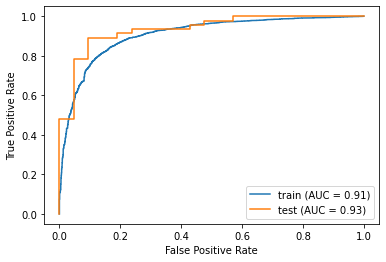

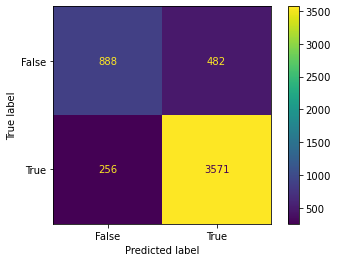

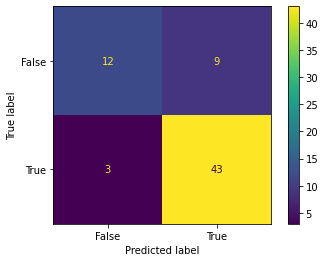

In [34]:
# Call our logreg function on data
logreg(X_train_best_log, X_test_best_log, y_train, y_test)

## K-Nearest Neighbors

Create a K-Nearest Neighbors function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print scoring metrics to assess how well the model performs.

Number of Neighbors: 7
Metric: manhattan
Weights: distance
Mean Cross-Val Score: 0.8299200414599838
Train Mean Accuracy: 1.0
Test Mean Accuracy: 0.7910447761194029
Recall Score: 0.9347826086956522
Precision Score: 0.7962962962962963
F1 score: 0.8599999999999999


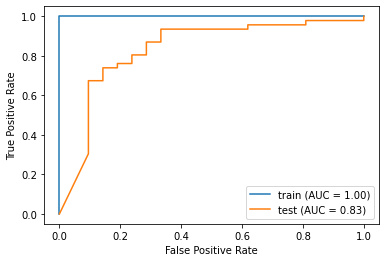

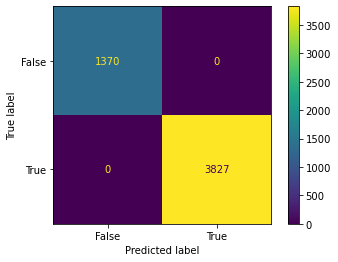

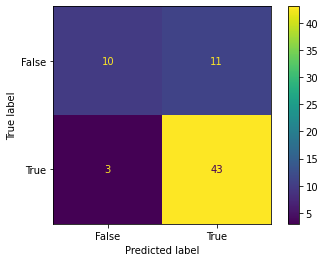

In [10]:
# Call our knn function on data
knn(X_train_scaled, X_test_scaled, y_train, y_test)

## Decision Tree

Create a Decision Tree function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print scoring metrics to assess how well the model performs.

In [11]:
# Use feature selection function to obtain best feature to use on this decision tree model
dtree_feats=feature_select(X_train_scaled,y_train,DecisionTreeClassifier,min_features=10)
X_train_best_dtree=X_train[dtree_feats]
X_test_best_dtree=X_test[dtree_feats]

Max Depth: 10
Min Sample Split: 15
criterion: entropy
Mean Cross-Val Score: 0.7741067594580587
Train Mean Accuracy: 0.9078314412160862
Test Mean Accuracy: 0.746268656716418
Recall Score: 0.8478260869565217
Precision Score: 0.7959183673469388
F1 score: 0.8210526315789473


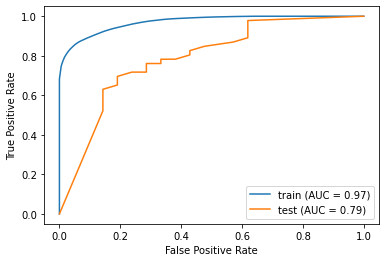

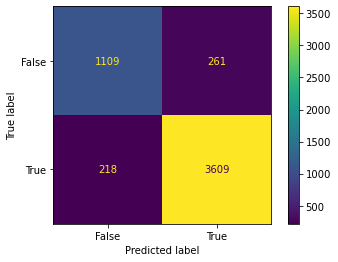

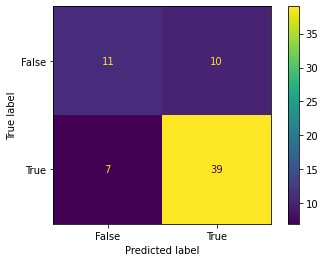

In [12]:
# Call our decision tree function on data
dtree(X_train_best_dtree, X_test_best_dtree, y_train, y_test)

## Random Forest

Create a Random Forest function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print scoring metrics to assess how well the model performs.

In [40]:
# Use feature selection function to obtain best feature to use on this random forest model
random_forest_feat=feature_select(X_train_scaled,y_train,RandomForestClassifier,min_features=10)
X_train_best_rforest=X_train_scaled[random_forest_feat]
X_test_best_rforest=X_test_scaled[random_forest_feat]

Number of Trees: 110
Criterion: entropy
Mean Cross-Val Score: 0.8516606204190419
Train Mean Accuracy: 1.0
Test Mean Accuracy: 0.8656716417910447
Recall Score: 0.9565217391304348
Precision Score: 0.8627450980392157
F1 score: 0.9072164948453608


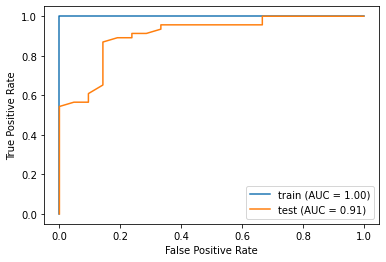

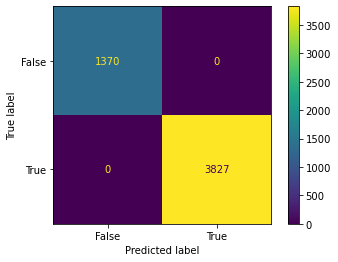

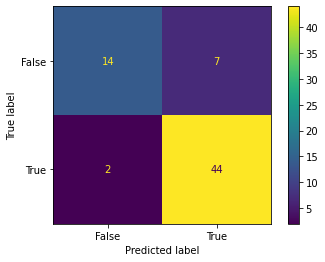

In [41]:
# Call our random forest function on the data
random_forest(X_train, X_test, y_train, y_test, cv=5)

## Bagging Classifier

Create a Bagging Classifier function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print scoring metrics to assess how well the model performs.

Dec Tree Max Depth: 2
Dec Tree Criterion: gini
Bagging Max Samples: 5
Bag Max Features: 3
# of Base Estimators: 50
Mean Cross-Val Score: 0.7360017028207595
Train Mean Accuracy Score: 0.7363863767558206
Test Mean Accuracy Score: 0.6865671641791045
Recall Score: 1.0
Precision Score: 0.6865671641791045
F1 score: 0.8141592920353982


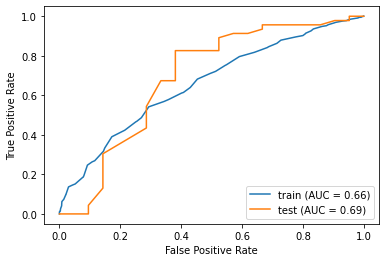

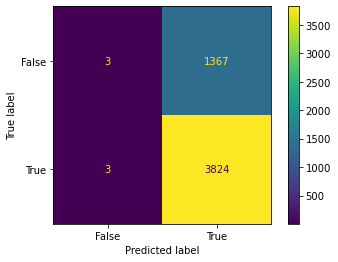

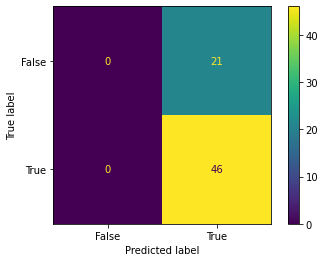

In [42]:
# Call our bagging classifier function on data
bagged(X_train, X_test, y_train, y_test, cv=5)

## XGBoost

Create an XGBoost function to use GridSearchCV, find the best hyperparameters and then create a model with those results and values. Also print scoring metrics to assess how well the model performs.

XGBoost Learning Rate: 0.1
XGBoost Max Depth: 4
XGBoost Min Child Weight: 3
XGBoost Subsample: 1
XGBoost Estimators: 500
Mean Cross-Val Score: 0.8657131487376916
Train Mean Accuracy Score: 1.0
Test Mean Accuracy Score: 0.8507462686567164
Recall Score: 0.8913043478260869
Precision Score: 0.8913043478260869
F1 score: 0.8913043478260869


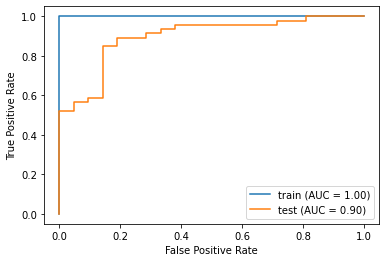

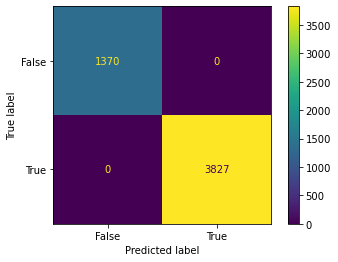

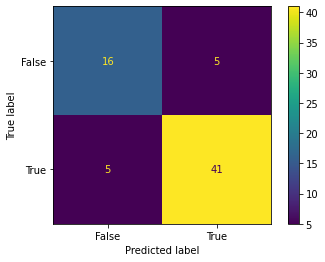

In [43]:
# Call our XGBoost function on data
xgboost(X_train, X_test, y_train, y_test, cv=5)

# Model Comparison
***

Comparing mean accuracy score and mean standard deviation across top 3 performing models on regular season.

In [44]:
logreg_season = [.8201, .7910, .7612, .8209, .7612]
mean_logreg_season = round(np.mean(logreg_season), 5)
std_logreg_season = round(np.std(logreg_season), 5)

rf_season = [.73, .73, .7313, .8358, .776]
mean_rf_season = round(np.mean(rf_season), 5)
std_rf_season = round(np.std(rf_season), 5)

xgb_season = [.86, .79, .7313, .8507, .776]
mean_xgb_season = round(np.mean(xgb_season), 5)
std_xgb_season = round(np.std(xgb_season), 5)

print(f"Mean Log_Reg: {mean_logreg_season}\nStd Log_Reg: {std_logreg_season}")
print(f"\nMean Random Forest: {mean_rf_season}\nStd Random Forest: \
{std_rf_season}")
print(f"\nMean XGBoost: {mean_xgb_season}\nStd XGBoost: {std_xgb_season}")



Mean Log_Reg: 0.79088
Std Log_Reg: 0.02652

Mean Random Forest: 0.76062
Std Random Forest: 0.04153

Mean XGBoost: 0.8016
Std XGBoost: 0.04807


Comparing mean accuracy score and mean standard deviation across top 3 performing models on postseason.

In [45]:
logreg_post = [.84, .72, .81, .82, .81]
mean_logreg_post = round(np.mean(logreg_post), 5)
std_logreg_post = round(np.std(logreg_post), 5)

rf_post = [.81, .75, .79, .76, .81]
mean_rf_post = round(np.mean(rf_post), 5)
std_rf_post = round(np.std(rf_post), 5)

xgb_post = [.79, .78, .77, .73, .75]
mean_xgb_post = round(np.mean(xgb_post), 5)
std_xgb_post = round(np.std(xgb_post), 5)

print(f"Mean logreg_post: {mean_logreg_post}\nStd Log_Reg: {std_logreg_post}")
print(f"\nMean rf_post: {mean_rf_post}\nStd Random Forest: \
{std_rf_post}")
print(f"\nxgb_post: {mean_xgb_post}\nStd XGBoost: {std_xgb_post}")



Mean logreg_post: 0.8
Std Log_Reg: 0.04147

Mean rf_post: 0.784
Std Random Forest: 0.02498

xgb_post: 0.764
Std XGBoost: 0.02154


# Conclusion

The results of our logistic regression model in the tournament are very strong:

- Overall 82% mean accuracy score for single-game predictions
- 71% mean accuracy score for underdog predictions

As such, we recommend following the model's underdog predictions for the duration of the tournament. Doing so will help maximize returns.

For next steps, we'd like to explore the following:

- Integrate moneyline data to further identify value
- Incorporate more player-specific data to predict how a player will perform on a given day
- Look at adjusting bet sizing to implement risk-adjusted wagers